# Computer Vision Projects

## Epipolar Geometry & 8-Point Algorithm

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def normalize_points(points):
    """
    Normalizes a set of points.

    Parameters:
    points (np.ndarray): An array of 2D points.

    Returns:
    tuple: A tuple containing the normalized points and the normalization matrix.
    """
    centroid = np.mean(points, axis=0)
    shifted_points = points - centroid
    
    dist = np.linalg.norm(shifted_points, axis=1)
    avg_dist = np.mean(dist)

    scale = np.sqrt(2) / avg_dist

    T = np.array([[scale, 0, -scale * centroid[0]],
                  [0, scale, -scale * centroid[1]],
                  [0, 0, 1]])
    
    points_normalized = np.dot(T, np.vstack((points.T, np.ones((1, points.shape[0])))))
    return points_normalized.T, T

In [3]:
def get_coordinates(file): 
    coordinates = []
    with open(file, "r") as coordinates_files:
        for line in coordinates_files:
            y, x = map(float, line.split())
            coordinates.append((x, y))
    coordinates = np.array(coordinates)
    return coordinates

<Figure size 640x480 with 0 Axes>

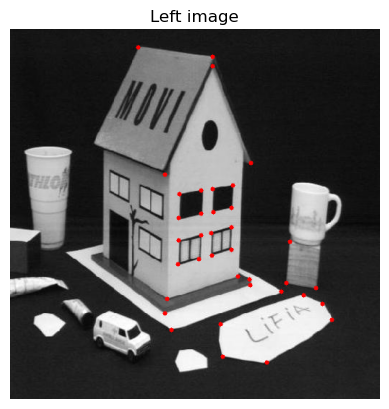

<Figure size 640x480 with 0 Axes>

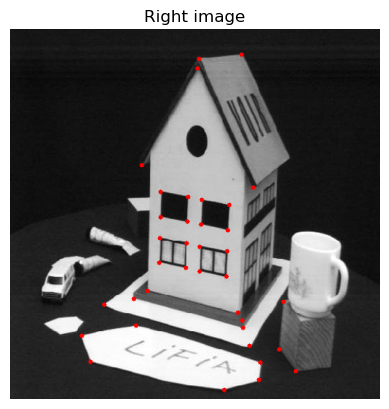

In [4]:
def visualize_points(image, title, coordinates):
    img = image.copy()
    plt.figure()
    for point in coordinates:
        img = cv2.circle(img, (int(point[0]),int(point[1])), radius=3, color=(255, 0, 0), thickness=-1)
    plt.show()
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    return

left = cv2.imread('images/image_left.jpg')
coordinates_left = get_coordinates('images/pt_2D_left.txt')
visualize_points(left, 'Left image', coordinates_left)

right = cv2.imread('images/image_right.jpg')
coordinates_right = get_coordinates('images/pt_2D_right.txt')
visualize_points(right, 'Right image', coordinates_right)

In [5]:
def normalized_eight_points(left, right):
    norm_left, F_left = normalize_points(left)
    norm_right, F_right = normalize_points(right)
    A = []
    for i in range(norm_left.shape[0]):
        x0, y0 = norm_left[i, :2]
        x1, y1 = norm_right[i, :2]
        A.append([x0 * x1, y0 * x1, x1, y1 * x0, y1 * y0, y1, x0, y0, 1])
    A = np.array(A)
    
    # SVD de A
    U, S, Vt = np.linalg.svd(A)
    Fi = Vt[-1].reshape(3, 3)

    # Refuerzo de la restricción
    Uf, Sf, Vtf = np.linalg.svd(Fi)
    Sf[-1] = 0  # Fuerza a que el determinante sea 0
    F_prime = Uf @ np.diag(Sf) @ Vtf

    # Desnormalización
    F = F_right.T @ F_prime @ F_left
    return F

<Figure size 640x480 with 0 Axes>

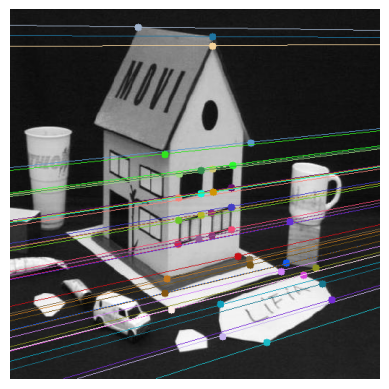

<Figure size 640x480 with 0 Axes>

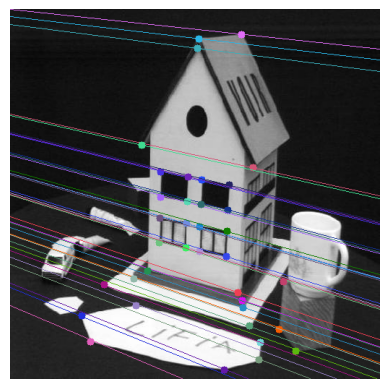

In [6]:
def drawlines(img, lines, pts1):
    _ ,c = img.shape[:2]
    for r, pt1 in zip(lines, pts1):
        pt1 = (int(pt1[0]), int(pt1[1]))
        color = tuple(np.random.randint(0,255,3).tolist())
        # Calcula los puntos iniciales y finales de la línea epipolar
        x0,y0 = map(int, [0, -r[2]/r[1]])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        # Dibuja la línea epipolar en img
        img = cv2.line(img, (x0,y0), (x1,y1), color, 1)
        # Dibuja los puntos correspondientes en img y img2
        img = cv2.circle(img, pt1, 5, color, -1)
    return img

F = normalized_eight_points(coordinates_left, coordinates_right)

lines1 = cv2.computeCorrespondEpilines(np.expand_dims(coordinates_right, axis=1), 2, F)
lines1 = lines1.reshape(-1,3)

# Ahora puedes llamar a drawlines con las imágenes y puntos originales
right_with_epilines = drawlines(left, lines1, coordinates_left)

plt.figure()
plt.show()
plt.imshow(cv2.cvtColor(right_with_epilines, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

lines2 = cv2.computeCorrespondEpilines(np.expand_dims(coordinates_left, axis=1), 1, F)
lines2 = lines2.reshape(-1,3)

# Ahora puedes llamar a drawlines con las imágenes y puntos originales
left_with_epilines = drawlines(right, lines2, coordinates_right)

plt.figure()
plt.show()
plt.imshow(cv2.cvtColor(left_with_epilines, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [7]:
F

array([[ 7.69564303e-07, -5.78773950e-06, -1.01011620e-03],
       [-6.28660670e-06, -4.01132413e-07,  1.04176782e-02],
       [ 1.04182564e-04, -7.58583623e-03,  1.72255185e-01]])